# Analysis of IMAGEN's questionnaires:
1. Demographics
2. Substance use
3. Psychological assessments
4. Socio-economic status

Reference documentation links:
* IMAGEN's native documentation: https://imagen-europe.com/resources/imagen-dataset/documentation/
* Our local documentation: https://github.com/ritterlab/deepMRI/wiki/IMAGEN
* Their github repositories: https://github.com/imagen2
* Evert's thesis: https://github.com/evertdeman/imagen_thesis
* Latest IMAGEN publications: https://imagen-europe.com/resources/publications/

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
from glob import glob 
from os.path import join

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set(style="darkgrid", color_codes=False)

from tqdm.notebook import tqdm

### load the variable to control

Variable controlling for:: Ctq-Denial-Sum


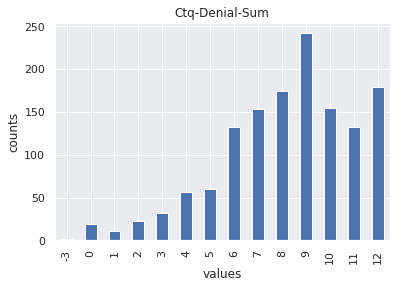

In [2]:
# for example, I will load the childhood abuse denial question from the Childhood Trauma questionnaire 
INSTRU_QUESTIONNAIRE="CTQ"
INSTRU_QUESTION="Denial sum"

# a unique name for the instrument to save filenames 
from slugify import slugify
INSTRU_NAME = slugify(INSTRU_QUESTIONNAIRE +'_'+ INSTRU_QUESTION)
print("Variable controlling for::", INSTRU_NAME.title())

instrument_df = pd.read_csv(f"/ritter/share/data/IMAGEN/posthoc/all_{INSTRU_QUESTIONNAIRE}.csv").set_index('ID')

    # select FU3 if available or else FU2 or else BL
if 'FU3' in instrument_df['Session'].unique():
    instrument_df = instrument_df.groupby('Session').get_group('FU3')
elif 'FU2' in instrument_df['Session'].unique():
    instrument_df = instrument_df.groupby('Session').get_group('FU2')
else:
    instrument_df = instrument_df.groupby('Session').get_group('BL')
    
instrument_df = instrument_df[INSTRU_QUESTION]
instrument_df.value_counts(dropna=False).sort_index().plot.bar(title=INSTRU_NAME.title(), xlabel='values', ylabel='counts')
plt.show()
# for help with other questionnaires, refer to the imagen_SS_roshan.ipynb notebook

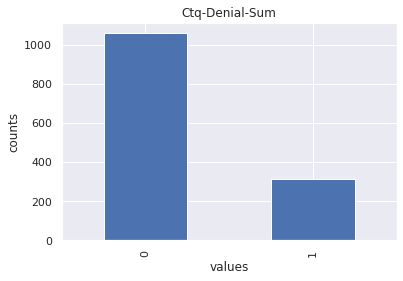

In [3]:
# binarize the question
instrument = instrument_df.copy()
instrument[instrument_df<11] =  0
instrument[instrument_df>=11] = 1
instrument.value_counts(dropna=False).sort_index().plot.bar(title=INSTRU_NAME.title(), xlabel='values', ylabel='counts')

plt.show()

### Create the H5 with the label (Binge drinkers vs controls) and the 2 confounds (sex and site)

In [13]:
# import the data loader
sys.path.append("../")
from imagen_dataloader import *

In [14]:
VIZ=True

imagen = Imagen()
# plot the demographics in the present IMAGEN dataset
# imagen.plot_demographics()

In [15]:
# add the instrument as a confound variable
imagen.df.loc[:, ("FU3",INSTRU_NAME)] = instrument
# for subjects missing this information, force the value to the majority class. This is a temporary workaround but may not be true, of course
imagen.df.loc[:, ("FU3",INSTRU_NAME)] = imagen.df.loc[:, ("FU3",INSTRU_NAME)].fillna(0)
# imagen.df.columns

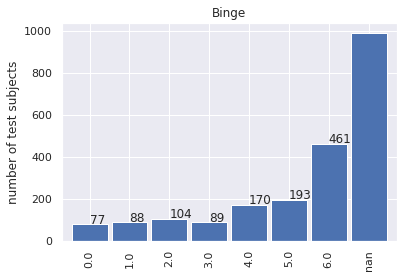

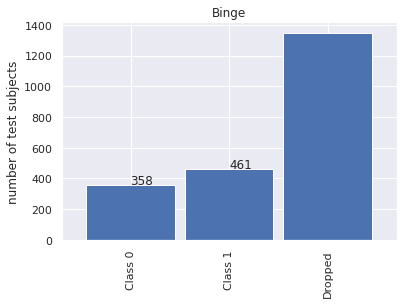

,Binge
ID,
1274,NaN
22453,NaN
75717,NaN
106601,NaN
106871,NaN
...,...
99747799,NaN
99826568,NaN
99873252,1.0


In [16]:
# load the 'Binge drinking' label from ESPAD questionnaire's 19a question
LBL_QUESTIONNAIRE="ESPAD_FU3"
LBL_QUESTION="19a"
LABEL_NAME = 'Binge'

dfq = pd.read_csv(qs[LBL_QUESTIONNAIRE], usecols=["User code", LBL_QUESTION], dtype={"User code":str})
dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
dfq = dfq.drop("User code", axis=1)
imagen.load_label(dfq, col=LBL_QUESTION,  viz=VIZ, binarize=True, class0=3, class1=6, y_colname=LABEL_NAME)

Safe users           299
Moderate misusers    336
Heavy misusers       400
Name: Binge, dtype: int64
Final dataframe prepared. 
Total subjects = 650
Distributions in final dataframe:


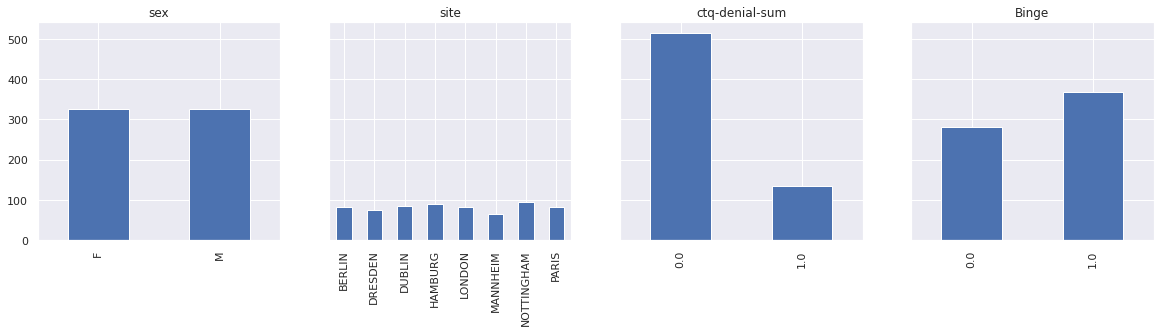

Total subjects = 650


In [17]:
# create the hdf5 file and plot the distributions in the final h5 file generated
imagen.prepare_X("FU3", confs=['sex', 'site', INSTRU_NAME], viz=VIZ) 
imagen.hdf5_name_x = 'posthoc-cc-'

<AxesSubplot:xlabel='Binge'>

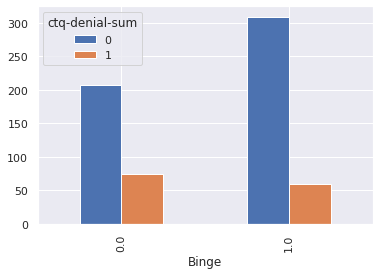

In [18]:
# the variable's distribution per class
imagen.df_out[[LABEL_NAME, INSTRU_NAME]].value_counts().unstack().plot.bar()

In [19]:
# save the h5 file you created
# give a unique suffix to it's name
imagen.hdf5_name_y = INSTRU_NAME
imagen.save_h5()

saving h5 file at /ritter/share/data/IMAGEN/h5files/posthoc-cc-ctq-denial-su-n650.h5


### Verify that the h5 file as as you expect

In [33]:
import h5py as h5
h5filename = glob('/ritter/share/data/IMAGEN/h5files/posthoc-cc-{}*.h5'.format(INSTRU_NAME[:-1]))[0]
h5file = h5py.File(h5filename, "r")
print('keys in h5:', h5file.keys())
print('n(X features) = ', len(h5file.attrs['X_col_names']))
print('confs = ', len(h5file.attrs['confs']))
h5file.close()

keys in h5: <KeysViewHDF5 ['Binge', 'X', 'ctq-denial-sum', 'i', 'sex', 'site']>
n(X features) =  719
confs =  3


In [27]:
!rm -rf /ritter/share/data/IMAGEN/h5files/posthoc-cc-ctq-denial-su-n531.h5

In [25]:
INSTRU_NAME

'ctq-denial-sum'